City Neighborhood Classifier 

CS 305: Machine Learning Fall 2021

Sara Clark, Christine Pourheydarian, Jiawei Liu


In [13]:
!pip3 install kaggle

In [54]:
import numpy as np
import pandas as pd
import csv
import random
random.seed(42)

In [55]:
'''
importing the calendar.csv data. 
listing id stays a number
date is kept in its form but has the dashes removed
available: if f, then becomes 0. if t, then becomes 1. 
price: converted from currency to a double. if there is no price, the value inserted is None. 
'''


from re import sub
from decimal import Decimal


calendar_csvfile = open('archive/calendar.csv', 'r')#listing_id,date,available,price
reader = csv.reader(calendar_csvfile, delimiter=',', quotechar='"')
calendar_data = []

for row in reader: 
    r  = [ ]
    for i in range(4):
        if i == 0:
            date = (row[1]).replace("-", "")
            r.append(date)
        elif i == 1:
            available = 0 if row[2] == "f" else 1 #f: 0, t: 1 
            r.append(available)
        elif i == 2:        
            money = row[3]
            if money == "":
                r.append(None)
                continue
            else: 
                value = float(Decimal(sub(r'[^\d.]', '', money)))#remove dollar sign, comma, and everything after the .
                r.append(value)
        elif i == 3: 
            listing_id  = int(row[0])
            r.append(listing_id)    
    calendar_data.append(r)


calendar_data_np = np.array(calendar_data)
print(calendar_data_np)

[['20170905' 0 None 12147973]
 ['20170904' 0 None 12147973]
 ['20170903' 0 None 12147973]
 ...
 ['20160908' 0 None 14504422]
 ['20160907' 0 None 14504422]
 ['20160906' 0 None 14504422]]


In [56]:
'''
Loading reviews.csv into numpy w/o any modification, i.e. w/o switching anything from qualitative to quantitative  
'''
from collections import defaultdict
csv_file = open('archive/reviews.csv', 'r')
reader = csv.reader(csv_file, delimiter=',', quotechar='"')
review_columns = []
data = []
reviews_and_ids = defaultdict(list) #key: listing id --> value: all comments corresponding to that listing id
for i, row in enumerate(reader):
    if i == 0:
        review_columns = row
        continue
    r = []
    for i in range(6):
        r.append(row[i])
    
    listing_id, review_text = row[0], row[-1]
    reviews_and_ids[listing_id].append(review_text)
    data.append(r)

csv_file.close()
reviews = np.array(data)
print("reviews columns:\n", review_columns)
print("reviews data:\n", reviews)

all_reviews = [ ] #list of reviews 
#each element of the corpus corresponds to all reviews of one listing concatenated together
for listing_id, reviews in reviews_and_ids.items():
    reviews_combined = "".join(reviews)
    all_reviews.append(reviews_combined)    

reviews columns:
 ['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments']
reviews data:
 [['1178162' '4724140' '2013-05-21' '4298113' 'Olivier'
  "My stay at islam's place was really cool! Good location, 5min away from subway, then 10min from downtown. The room was nice, all place was clean. Islam managed pretty well our arrival, even if it was last minute ;) i do recommand this place to any airbnb user :)"]
 ['1178162' '4869189' '2013-05-29' '6452964' 'Charlotte'
  'Great location for both airport and city - great amenities in the house: Plus Islam was always very helpful even though he was away']
 ['1178162' '5003196' '2013-06-06' '6449554' 'Sebastian'
  "We really enjoyed our stay at Islams house. From the outside the house didn't look so inviting but the inside was very nice! Even though Islam himself was not there everything was prepared for our arrival. The airport T Station is only a 5-10 min walk away. The only little issue was that all the people in the house 

In [57]:
# listings = np.loadtxt('archive/listings.csv', delimiter=',', skiprows = 1)
'''
but leaving out rows that dont have a value for host_neighborhood  and/or neighborhood 

'''
from re import sub
from decimal import Decimal


listings_csvfile = open('archive/listings.csv', 'r') 
reader = csv.reader(listings_csvfile, delimiter=',', quotechar='"')
listings_data = []
column = None 
property_types = {'': 0, 'Condominium': 1, 'Camper/RV': 2, 'House': 3, 'Townhouse': 4, 'Entire Floor': 5, 
              'Guesthouse': 6, 'Boat': 7, 'Dorm': 8, 'Villa': 9, 'Bed & Breakfast': 10, 'Other': 11, 'Apartment': 12, 
              'Loft': 13 }

room_types = {'Private room': 0, 'Shared room': 1, 'Entire home/apt': 2}
beds = {'Couch': 0, 'Airbed':1, 'Pull-out Sofa':2, 'Real Bed':3, 'Futon':4}
calendar_updated = {'never': 0, 'yesterday': 1, 'today': 2, '2 days ago': 3, '3 days ago': 4,
                    '4 days ago': 5, '5 days ago': 6, '6 days ago': 7, 'a week ago': 8, '1 week ago': 9,
                    '2 weeks ago': 10, '3 weeks ago': 11,'4 weeks ago': 12, '5 weeks ago': 13, '6 weeks ago': 14, 
                    '7 weeks ago': 15,'2 months ago': 16,'3 months ago': 17,'4 months ago': 18,'5 months ago': 19,
                    '7 months ago': 20,'6 months ago': 21, '8 months ago': 22,'9 months ago': 23,'10 months ago':24,
                    '11 months ago':25,'12 months ago':26, '13 months ago': 27, '14 months ago': 28, '15 months ago': 29, '16 months ago': 30, 
                    '17 months ago': 31, '18 months ago': 32, '20 months ago': 33, '22 months ago': 34, '30 months ago': 35, 
                    '23 months ago': 36, '25 months ago': 37 }
cancellation_policy = {'flexible': 0, 'moderate': 1, 'strict': 2, 'super_strict_30': 3}
indicesSet = set([0,19,32,33,48,49,53,54,55,56,59,65, \
                  67,68,71,72,73,74,76,79,80,81,82,83,84,85,93,94,50,86,89,91,92,51,52,57,\
                 60,61,62,63,64,66,69,90]) #columns included in the numpy array 
neighborhoods = [ ]
neighborhoodMatch = {} #a dictionary that maps a listing to a neighborhood tag in form "listing_id:neighborhood"

listing_columns = [ ]
for index, row in enumerate(reader): 
    if index == 0:
        listing_columns = row
        continue
    #removing rows without a listed neighborhood in either of these 4 columns that correspond to neighborhood
    host_neighbourhood = row[31]
    neighbourhood = row[38]
    neighbourhood_cleansed = row[39]
    neighbourhood_group_cleansed = row[40]
    
    listing_id = row[0]

    if not neighbourhood and not host_neighbourhood \
        and not neighbourhood_cleansed and not neighbourhood_group_cleansed:
        continue 
    #adding neighborhood from whatever column it's stored in
    if neighbourhood: 
        neighborhoods.append(neighbourhood)
        neighborhoodMatch[listing_id]=neighbourhood
    elif neighbourhood_cleansed:
        neighborhoods.append(neighbourhood_cleansed)
        neighborhoodMatch[listing_id]=neighbourhood_cleansed
    elif neighbourhood_group_cleansed:
        neighborhoods.append(neighbourhood_group_cleansed)
        neighborhoodMatch[listing_id]=neighbourhood_group_cleansed
        
        

    if index == 0:
        columns = row
    r  = [ ] #row values
    for i in range(95): #i is a column index 
        if index == 0 and i in indicesSet: #then this is the header column names
            r.append(row[i])
        elif i == 0 or i == 19 or i == 32 or i == 33 \
            or i == 48 or i == 49 or i == 53 or i == 54 or i == 55 or i == 56 or i == 59 \
            or i == 65 or i == 67 or i == 68 or (i >=71 and i <= 74) or i == 76 or (i >= 79 \
            and i <= 85) or i ==  93 or i == 94: #listing id, host id 
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                val = row[i] 
                r.append(val)
        elif i == 50 or i == 86 or i == 89 or i == 91 or i == 92:
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                boolean = 0 if row[i] == "f" else 1 
                r.append(boolean)
        elif i == 51:
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                property_type = property_types[row[i]]
                r.append(property_type)
        elif i == 52:
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                room_type = room_types[row[i]] 
                r.append(room_type)
        elif i == 57:
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                bed = row[i]
                r.append(beds[bed])
        elif (i >=  60 and i <= 64) or i == 66: 
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                money = row[i]
                value = float(Decimal(sub(r'[^\d.]', '', money)))#remove dollar sign, comma, and everything after the .
                r.append(value)
        elif i == 69: #calendar_updated col 
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                date = row[i]
                r.append(calendar_updated[date])  
        elif i == 90:
            if row[i] == "N/A" or row[i] == "":
                r.append(None)
                continue 
            else:
                policy = row[i]
                val = cancellation_policy[(policy)] 
                r.append(val)
        
    listings_data.append(r)

listings_numerical_data = np.array(listings_data)
neighborhoods = np.array(neighborhoods)
allLabels, labelsCounts = np.unique(neighborhoods, return_counts=True)
print("listing_columns\n", listing_columns)
print("listings data \n", listings_numerical_data[:5,:]) #first 5 rows
print("neighborhoods data \n", neighborhoods )
print("neighborhoods & listing matching \n", list(neighborhoodMatch.items())[:5]) # first 5 items

listing_columns
 ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', '

total # neighborhoods 
 23
Allston-Brighton Count : 432
Back Bay Count : 330
Beacon Hill Count : 210
Brookline Count : 12
Cambridge/Somerville Count : 22
Charlestown Count : 98
Chinatown Count : 84
Dorchester Count : 260
Downtown Count : 83
East Boston Count : 149
Fenway/Kenmore Count : 293
Hyde Park Count : 32
Jamaica Plain Count : 343
Mattapan Count : 28
Mission Hill Count : 122
North End Count : 145
Roslindale Count : 56
Roxbury Count : 148
South Boston Count : 258
South End Count : 330
Theater District Count : 34
West End Count : 74
West Roxbury Count : 42


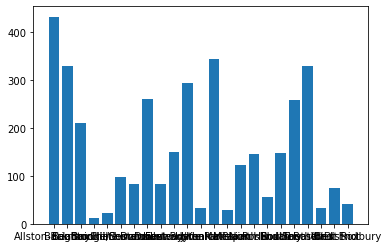

In [58]:
import matplotlib.pyplot as plt

#CONSOLIDATE BOSTON NEIGHBORHOODS
for count, neighborhood in enumerate(neighborhoods):
    if neighborhood in ['Cambridge','Harvard Square', 'Somerville']:
        neighborhoods[count] = "Cambridge/Somerville"
    elif neighborhood in ['Allston','Brighton']:
        neighborhoods[count] = "Allston-Brighton"
    elif neighborhood in ['Fenway', 'Longwood Medical Area']:
        neighborhoods[count] = "Fenway/Kenmore"
    elif neighborhood in ['Downtown Crossing','Government Center', 'Financial District', 'Leather District']:
        neighborhoods[count] = "Downtown"
    elif neighborhood == 'Bay Village':
        neighborhoods[count] = "Theater District"
    elif neighborhood == 'Chestnut Hill':
        neighborhoods[count] = "Brookline"
    elif neighborhood == 'South Boston Waterfront':
        neighborhoods[count] = "South Boston"
allLabels, labelsCounts = np.unique(neighborhoods, return_counts=True)
print("total # neighborhoods \n", len(allLabels) )
indices = np.arange(1,labelsCounts.shape[0]+1)
plt.bar(indices, labelsCounts, width=0.8, tick_label=allLabels)
for i in range(labelsCounts.shape[0]):
    print(allLabels[i], "Count :", labelsCounts[i])


Christine's to-dos:
-  remove stuff internally used
- leave dates in date form 
- join on the reviews

Text Analysis
- Remove neighborhood names from text-based feature columns used for training
- Bag of words: tfid vectorization
- Link reviews to correct neighborhood



In [59]:
#Here is where Jiawei and Sara will do text analysis
# split data by neighborhood

# def readSpamData(ham_filename, spam_filename):
#     DATA = []

#     # Read in ham messages from file
#     ham_file = open(ham_filename, 'r')
#     messages = ham_file.read().split('*****@@@@@%%%%%*****@@@@@%%%%%')
#     for message in messages: DATA.append([message, 0])
#     ham_file.close()
    
#     # Read in spam messages from file
#     spam_file = open(spam_filename, 'r')
#     messages = spam_file.read().split('*****@@@@@%%%%%*****@@@@@%%%%%')
#     for message in messages: DATA.append([message, 1])
#     spam_file.close()

#     random.shuffle(DATA)  # Shuffle
#     return [row[0] for row in DATA], [row[1] for row in DATA]

# corpus, labels = readSpamData('ham.txt', 'spam.txt')


corpus = reviews[:,5] 
listingID = reviews[:,0]
labels = []
for i in listingID:
    labels.append(neighborhoodMatch[i])
print(len(corpus))
print(len(labels))
print(len(reviews))
print(corpus[:5])
print(listingID[:5])
print(labels[:5])


# Separate into training and testing data
TEST_SIZE = 0.25  
# MAKE SURE ITS SPLIT BEFORE USING!!!!!

separator = int((1.0 - TEST_SIZE)*len(corpus))
corpus_train = corpus[:separator]
labels_train = labels[:separator]
corpus_test = corpus[separator:]
labels_test = labels[separator:]
print(len(corpus_train))
print(len(labels_train))
print(len(corpus_test))
print(len(labels_test))

TypeError: list indices must be integers or slices, not tuple

In [60]:
# Text feature extraction for training data
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()  # Use individual words as tokens
X_train = vectorizer.fit_transform(corpus_train)
y_train = np.array(labels_train)
print(X_train.shape)
print(y_train.shape)
# print(X_train[:5])

NameError: name 'corpus_train' is not defined

In [ ]:
# Text feature extraction for testing data
X_test = vectorizer.transform(corpus_test)
y_test = np.array(labels_test)
print(X_test.shape)
print(y_test.shape)

In [ ]:
%%time
# Use different classifiers to predict neighborhood label
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn import ensemble  # Using RandomForest classifier
from sklearn import neighbors  # Using nearest neighbors classifier
learners = {'Perceptron': linear_model.Perceptron(max_iter=10),
#             'RandomForest': ensemble.RandomForestClassifier(),
            'kNN': neighbors.KNeighborsClassifier()
           }
for classifierName in learners:
    learners[classifierName].fit(X_train, y_train)
    print('Accuracy of ' + classifierName + ':\t' + str(learners[classifierName].score(X_test, y_test)))
    

In [ ]:
# Get Perceptron weights
learner = linear_model.Perceptron(max_iter=10)
learner.fit(X_train, y_train)
weights = learner.coef_  # Get the learned Perceptron weights
# sorted_weights = np.argsort(weights)  # Sort
features = vectorizer.get_feature_names()  # Get the features
print(weights.shape)

print('\nClassName : weight pair: ')
for n in range(weights.shape[0]): 
    print("\nNeighborhood: "+str(y_train[n]))
    for i in range(25): 
        print("\nClassName: "+str(features[i])+" Weights: "+str(weights[n,i]))


# print('\nLowest weighted words (indicative of negative sentiment tweets)')
# for i in range(25): print(features[sorted_weights[0,i]])
# print('\nHighest weighted words (indicative of positive sentiment tweets)')
# for i in range(25): print(features[sorted_weights[0,len(sorted_weights[0])-i-1]])

Feature Scaling

In [ ]:
#split data. rows already randomly permuted

# Split data into training (80%) and testing (20%).
# Use feature scaling to standardize the features.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X = listings_numerical_data
y = neighborhoods

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

def scaleData(trainX, testX):
    scaler = StandardScaler()
    scaler.fit(trainX)
    return scaler.transform(trainX), scaler.transform(testX)

X_train, X_test = scaleData(X_train, X_test)

split into training and testing
- first organize stuff by neighborhood
- randomly permute rows of each neighborhood set
- then select 25% of each neighborhood for testing and the rest for training
- combine the testing components and the training components

- **** we also planned to do cross validation, but maybe we can revisit that later?


In [ ]:
# Split data into training (80%) and testing (20%) and randomly permute rows
# Use feature scaling to standardize the features.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
def scaleData(trainX, testX):
    scaler = StandardScaler()
    scaler.fit(trainX)
    return scaler.transform(trainX), scaler.transform(testX)

X_train, X_test = scaleData(X_train, X_test)

In [ ]:
# Cross validation

Create Classification models
- kNN
- random forest
- SVM
- Logistic Regression
- Neural Network (or Perceptron)




In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model  # Using sklearn Perceptron classifier
from sklearn import ensemble  # Using RandomForest classifier
from sklearn.svm import SVC

from sklearn import neighbors  # Using nearest neighbors classifier
# learners = {'Perceptron': linear_model.Perceptron(max_iter=10),
#             'RandomForest': ensemble.RandomForestClassifier(),
#             'kNN': neighbors.KNeighborsClassifier(),
#             'SVM': SVC(),
#             'LogisticRegression': linear_model.LogisticRegression(random_state=42)
#            },
           }
# for classifierName in learners:
#     learners[classifierName].fit(X_train, y_train)
#     print('Accuracy of ' + classifierName + ':\t' + str(learners[classifierName].score(X_test, y_test)))

In [ ]:
#Here is where Jiawei will do NN
# Get Perceptron weights
# learner = linear_model.Perceptron(max_iter=1)
learner.fit(X_train, y_train)
weights = learner.coef_  # Get the learned Perceptron weights
sorted_weights = np.argsort(weights)  # Sort
features = vectorizer.get_feature_names()  # Get the features
print('\nLowest weighted words (indicative of ham)')
for i in range(5): print(features[sorted_weights[0,i]])
print('\nHighest weighted words (indicative of spam)')
for i in range(5): print(features[sorted_weights[0,len(sorted_weights[0])-i-1]])